In [1]:
import sys
import os
import csv

import pickle
import copy
import ase.io
import numpy as np
import torch

from amptorch.trainer import AtomsTrainer
from numpy.random import default_rng

from sklearn.neighbors import KDTree
from sklearn.preprocessing import StandardScaler

from scipy.stats import gaussian_kde
import matplotlib
from matplotlib import pyplot as plt
from shutil import rmtree
import copy
from ase.calculators.singlepoint import SinglePointCalculator
import time


def load_training_data(training_filename, test_filename):

    training_list = ase.io.read(training_filename, index=":")
    test_list = ase.io.read(test_filename, index=":")

    return training_list, test_list

def write2csv(csv_filename, message, header=None):
    if os.path.exists(csv_filename) is False:
        if header is not None:
            with open(csv_filename, "w", newline="") as f:
                writer = csv.writer(f, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
                writer.writerow(header)

    with open(csv_filename, "a", newline="") as f:
        writer = csv.writer(f, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(message)
    return


def calc_dist(train_X, calib_X, nearest_neighbors=10, metric="minkowski"):
    std_scaler = StandardScaler().fit(train_X)
    train_X_std_scaled = std_scaler.transform(train_X)
    calib_X_std_scaled = std_scaler.transform(calib_X)
    
    kdtree = KDTree(train_X_std_scaled, metric=metric)
    dist, ind = kdtree.query(calib_X_std_scaled, k=nearest_neighbors)
    
    return dist.mean(axis=1)


def predict_data(pred_energies, test_images):
    
    true_energies = np.array([image.get_potential_energy() for image in test_images])

    list_of_error_per_atom = []

    for i, image in enumerate(test_images):
        num_atoms = len(image.get_atomic_numbers())
        total_energy_pred = pred_energies[i]
        total_energy_true = true_energies[i]

        error = pred_energies[i] - true_energies[i]
        per_atom_error = error / num_atoms
        list_of_error_per_atom.append(per_atom_error)

    return list_of_error_per_atom

class ConformalPrediction():
    def __init__(self, residuals_calib, heurestic_uncertainty_calib, alpha) -> None:
        # score function
        scores = abs(residuals_calib / heurestic_uncertainty_calib)
        scores = np.array(scores)

        n=len(residuals_calib)
        qhat = torch.quantile(torch.from_numpy(scores), np.ceil((n + 1) * (1 - alpha)) / n)
        qhat_value = np.float64(qhat.numpy())
        self.qhat = qhat_value
        pass

    def predict(self, heurestic_uncertainty_test):
        return heurestic_uncertainty_test * self.qhat, self.qhat

    
def prepare_featureNerror_from_trainer(trainer, images, image_type, get_descriptors=True):
    predictions = trainer.predict(images, get_descriptors=get_descriptors)
    feature = np.array(predictions["descriptors"])

    # errors for train, test, calib
    if image_type in ["test", "calib", "train"]:
        y_bar = np.array(predictions["energy"])
        list_error = predict_data(y_bar, images)
        list_error = np.array(list_error)
    else:
        raise NotImplementedError  

    return feature, list_error

def split_test_calib(full_test_X, full_test_y, per_calib, seed=0):
    # sub-select calib and test
    np.random.seed(seed)

    # num_total=5000
    num_total = len(full_test_X)

    num_calib = round(per_calib * num_total)

    rand_idx = np.random.choice(num_total, size=num_total, replace=False)
    calib_idx = rand_idx[:num_calib]
    test_idx = rand_idx[num_calib::]

    calib_X = [full_test_X[_] for _ in calib_idx]
    test_X = [full_test_X[_] for _ in test_idx]

    calib_y = [full_test_y[_] for _ in calib_idx]
    test_y = [full_test_y[_] for _ in test_idx]

    return test_X, test_y, calib_X, calib_y

def calc_uncertainty_metrics(list_error, uncertainty):
    overconfident_idx = np.argwhere(abs(list_error) > uncertainty)

    prob_overconfidence = len(overconfident_idx) / len(uncertainty)
    avg_uncertainty = np.mean(uncertainty)
    
    return prob_overconfidence, avg_uncertainty

def get_result_hash(parameter_string):
    string = str(parameter_string)
    md5 = hashlib.md5(string.encode("utf-8"))
    hash_result = md5.hexdigest()
    return hash_result

In [2]:

# user-defined parameters 
num_nearest_neighbors = 10
per_calib = 0.1
metric = "minkowski"
seed = 1

# fixed model parameters
path2config = <input checkpoint dir> # checkpoint dir by training

In [3]:
# plot setting
# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)
colors=["#f14432", "#fc8a6a"]

matplotlib.rcParams.update(matplotlib.rcParamsDefault)

# Set figure defaults
width = 6.5 / 3
fontsize = 10
rc = {'figure.figsize': (width, width),
#       'font.family': "serif",
      'font.size': fontsize,
      'axes.labelsize': fontsize,
      'axes.titlesize': fontsize,
      'xtick.labelsize': 'small',
      'ytick.labelsize': 'small',
      'legend.fontsize': fontsize}

matplotlib.rcParams.update(rc)

In [4]:
trial=50000

train_filename = <input train dataset dir>
test_filename = <input test dataset dir>
train_list, test_list = load_training_data(train_filename, test_filename)


In [5]:
print("Calculating feature representation...")
# load trainer
trainer = AtomsTrainer()
trainer.load_pretrained(path2config)

# obtain the features
train_X, train_y = prepare_featureNerror_from_trainer(trainer, train_list, "train")
full_test_X, full_test_y = prepare_featureNerror_from_trainer(trainer, test_list, "train")

# save the latent space features and energies
# pickle.dump(train_X, open(full_train_X_filename, "wb"))
# pickle.dump(train_y, open(full_train_y_filename, "wb"))
# pickle.dump(full_test_X, open(full_test_X_filename, "wb"))
# pickle.dump(full_test_y, open(full_test_y_filename, "wb"))
# pickle.dump(t_latent_prep, open(t_latent_prep_filename, "wb"))

Calculating feature representation...
Loading checkpoint from ./checkpoints/2022-02-03-17-52-17-data50000-ordernorm_sigma10logwide_MCSH3_NN32_constrs1.0_sh1
Use Xavier initialization
Loading model: 11393 parameters
Loading skorch trainer


In [6]:
train_X.shape

(50000, 40)

In [7]:
# predict test and calib
test_X, test_y, calib_X, calib_y = split_test_calib(full_test_X, full_test_y, per_calib, seed=seed)
train_X = np.array(train_X)
train_y = np.array(train_y)
test_X = np.array(test_X)
test_y = np.array(test_y)
calib_X = np.array(calib_X)
calib_y = np.array(calib_y)

# convert energy from kcal/mol to meV/sys
train_y *= 0.04336 * 1000
test_y *= 0.04336 * 1000
calib_y *= 0.04336 * 1000

# calculating the distance metric for test+calib
t0 = time.time()
calib_dist = calc_dist(train_X, calib_X, nearest_neighbors=num_nearest_neighbors, metric=metric)
test_dist = calc_dist(train_X, test_X, nearest_neighbors=num_nearest_neighbors, metric=metric)

In [8]:
plt.hist(test_y)

(array([  13.,   44.,  225.,  935., 3896., 8146., 4600.,  896.,  131.,
          14.]),
 array([-10.03576751,  -8.22273513,  -6.40970276,  -4.59667038,
         -2.78363801,  -0.97060564,   0.84242674,   2.65545911,
          4.46849149,   6.28152386,   8.09455624]),
 <BarContainer object of 10 artists>)

In [9]:
plt.hist(test_dist)

(array([4.600e+02, 9.180e+03, 7.427e+03, 1.572e+03, 2.150e+02, 4.200e+01,
        3.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([0.82686405, 1.33438998, 1.84191591, 2.34944184, 2.85696776,
        3.36449369, 3.87201962, 4.37954555, 4.88707148, 5.39459741,
        5.90212334]),
 <BarContainer object of 10 artists>)

In [10]:
# conformal prediction
alpha1 = 1-0.68
model_cp1 = ConformalPrediction(calib_y, calib_dist, alpha=alpha1)
test_uncertainty1, qhat1 = model_cp1.predict(test_dist)

alpha2 = 1-0.95
model_cp2 = ConformalPrediction(calib_y, calib_dist, alpha=alpha2)
test_uncertainty2, qhat2 = model_cp2.predict(test_dist)

In [11]:
import matplotlib.patheffects as PathEffects

def plot_scatter_residuals_vs_heurestic_uncertainty(heurestic_uncertainty_test, residuals_test, qhats, ps, xlabel="latent dist. [a.u.]", title=None, save_filename=None,dpi=300):
    heurestic_uncertainty_test = copy.deepcopy(heurestic_uncertainty_test)
    residuals_test = copy.deepcopy(residuals_test)
    qhat1, qhat2 = qhats
    p_1, p_2, p_3 = ps
    
    ref_fx = np.linspace(np.amin(heurestic_uncertainty_test), np.amax(heurestic_uncertainty_test), 100)
    xy = np.vstack([heurestic_uncertainty_test, residuals_test])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    heurestic_uncertainty_test, residuals_test, z = heurestic_uncertainty_test[idx], residuals_test[idx], z[idx]

    fig, ax = plt.subplots()

    ax.plot(ref_fx, ref_fx * qhat1,c=colors[0])
    ax.plot(ref_fx, - ref_fx * qhat1,c=colors[0])

    ax.plot(ref_fx, ref_fx * qhat2,c=colors[1])
    ax.plot(ref_fx, - ref_fx * qhat2,c=colors[1])
    
    ax.fill_between(ref_fx, ref_fx * qhat1, - ref_fx * qhat1, alpha=0.2, color=colors[0], linewidth=0)
    ax.fill_between(ref_fx, ref_fx * qhat2, - ref_fx * qhat2, alpha=0.2, color=colors[1], linewidth=0)
    ax.plot(ref_fx, [0]*100, "--", color="darkgray")

    x_lower_lim = np.quantile(heurestic_uncertainty_test, 1e-4)
    x_upper_lim = np.quantile(heurestic_uncertainty_test, 0.998)
    
    # force share-y
    ax.set_xlim([x_lower_lim, x_upper_lim])
    ax.set_ylim([-7.5, 7.5])
    
    # add text of prob
    prob_posi = (x_upper_lim - x_lower_lim) * .8
    txt = ax.text(2.7, 1.2, "{:.0f}%".format(p_1*100), color=colors[0])
    txt.set_path_effects([PathEffects.withStroke(linewidth=1.5, foreground='w')])
    txt = ax.text(2.7, 4.5, "{:.0f}%".format(p_2*100), color=colors[1])
    txt.set_path_effects([PathEffects.withStroke(linewidth=1.5, foreground='w')])
    txt = ax.text(2.4, 6.2, "{:.0f}%".format(p_3*100), color="k")
    txt.set_path_effects([PathEffects.withStroke(linewidth=1.5, foreground='w')])

    ax.scatter(heurestic_uncertainty_test, residuals_test, c=z, s=20, alpha=.2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("residual [meV/sys]")

    if title is not None:
        ax.set_title(title)
    # if save_filename is not None:
    #     fig.savefig(save_filename)
    # if dpi is not None:
    #     fig.savefig(save_filename, dpi=dpi, bbox_inches="tight", transparent=True)
    
    return fig, ax

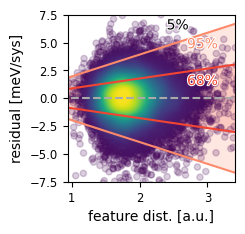

In [12]:
# quantify uncertainty
overconfident_idx1 = np.argwhere(abs(test_y) > test_uncertainty1)
overconfident_idx2 = np.argwhere(abs(test_y) > test_uncertainty2)

p1 = 1 - len(overconfident_idx1) / len(test_uncertainty1)
p2 = 1 - len(overconfident_idx2) / len(test_uncertainty2)
p3 = 1 - p2

fig_filename = "./figures/panel_method_comparison/cp_feature_dpi300.png"
fig, ax = plot_scatter_residuals_vs_heurestic_uncertainty(test_dist, test_y, (qhat1, qhat2), (p1, p2, p3), xlabel="feature dist. [a.u.]", save_filename=fig_filename)
fig
# plot_scatter_residuals_vs_heurestic_uncertainty(test_dist, list_epa_test, qhat, xlabel="latent dist. [a.u.]", save_filename=fig_filename)


In [13]:
np.mean(test_y)

-0.05067788875056689

In [14]:
np.mean(test_uncertainty1)

1.6777220081885507

In [15]:
plt.hist(test_uncertainty1,bins=100)
plt.xlabel("uncertainty")
plt.ylabel("frequency")

# plt.hist(test_uncertainty2)

Text(23.999999999999993, 0.5, 'frequency')

In [16]:
plt.hist(test_uncertainty2,bins=100)
plt.xlabel("uncertainty")
plt.ylabel("frequency")

Text(23.999999999999993, 0.5, 'frequency')

In [17]:
# analyze which the portion of test data in between one to two std

from scipy.stats import norm

# count the number of instances

expected_stds = np.linspace(norm.ppf(1e-3),
                norm.ppf(1-1e-3), 15)

expected_ps = []
observed_ps = []
test_uncertainties = []

for std in expected_stds: 

    expected_p = norm.cdf(std)
    expected_ps.append(expected_p)
    
    alpha = 1-expected_p
    model_cp = ConformalPrediction(calib_y, calib_dist, alpha=alpha)
    test_uncertainty, qhat = model_cp.predict(test_dist)
    
    count = np.sum(np.abs(test_y) < test_uncertainty)
    observed_ps.append(count / len(test_y))
    test_uncertainties.append(np.mean(test_uncertainty))


In [18]:
# calculate the area of miscalculation in calibration curve

from scipy.integrate import trapz as trapezoid

area = 0

for i in range(1, len(observed_ps)+1):
    trap = np.abs(trapezoid(observed_ps[i-1:i+1], expected_ps[i-1:i+1]) 
                  - trapezoid(expected_ps[i-1:i+1], expected_ps[i-1:i+1]))
    area += trap

area

0.009428137449860145

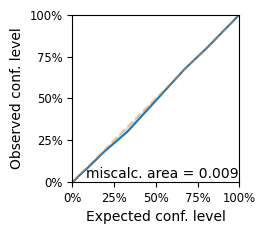

In [19]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots(figsize=(width, width))
expected_ps = np.array(expected_ps) * 100 # convert to %
observed_ps = np.array(observed_ps) * 100 # convert to %

ax.plot(expected_ps, observed_ps)
ax.plot(expected_ps, expected_ps, "--", alpha=0.4)

ax.fill_between(expected_ps, expected_ps, observed_ps, alpha=0.2, linewidth=0)
ax.set_xlim([0, 100])
ax.set_ylim([0, 100])
ax.set_aspect('equal')

ax.set_xlabel("Expected conf. level")
ax.set_ylabel("Observed conf. level")
ax.locator_params(axis='y', nbins=4)
ax.locator_params(axis='x', nbins=4)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.text(8, 2, "miscalc. area = {:.3f}".format(area))

save_filename = "./figures/panel_method_comparison/cp_feature_calibration_curve.pdf"
# fig.savefig(save_filename,bbox_inches='tight')
fig